In [12]:
import os
%load_ext autoreload
%autoreload 2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import json
import numpy as np
import matplotlib.patches as mpatches

game_titles = {
    "shuffleKeys_game": "Switching Mappings Keys Game",
    "shuffleKeys_game_final": "Switching Mappings Keys Game",
    "contingency_game": "Contingency Game",
    "contingency_game_final": "Contingency Game",
    "contingency_game_0": "Contingency Game (Single Seed)",
    "contingency_game_lrtest": "Contingency Game (Single Seed)",
    "contingency_game_r0": "Contingency Game (Agent Placement is Constant Among Each Level)",
    "contingency_game_diff_color": "Contingency Game (Real Agent is Blue)",
    "contingency_game_shuffled": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_1": "Switching Mappings Game (Switched Every Level)",
    "contingency_game_shuffled_100": "Switching Mappings Game (Switched Once in Every 100 Levels)",
    "contingency_game_shuffled_200": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_final": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "contingency_game_shuffled_1_final": "Switching Mappings Game (Switched Every Level)",
    "contingency_game_shuffled_100_final": "Switching Mappings Game (Switched Once in Every 100 Levels)",
    "contingency_game_shuffled_200_final": "Switching Mappings Game (Switched Once in Every 200 Levels)",
    "logic_game": "Logic Game",
    "logic_game_final": "Logic Game",
    "logic_game_0": "Logic Game",
    "logic_game_lrtest": "Logic Game",
    "logic_extended_game": "Ext Logic",
    "change_agent_game": "Switching Embodiments Game",
    "change_agent_game_final": "Switching Embodiments Game",
    "change_agent_game_lrtest": "Switching Embodiments Game (Single Seed)"

}

label_dict = {'human': 'Human', 'self_class': 'Self Class', 'dqn_training': 'DQN',
              'random': 'Random', 'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training': 'PPO2',
              'acer_training': 'ACER'}


def ts_plotter(self, ax, data1, data2):
    '''
    Helper for plotting panels in time series plot.
    '''

    out = ax.plot(data1, data2, linewidth=2)
    return out

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def get_performance(game_types, agent_types, batch_size=10, single_seed=False):
    ''' Plot performance for games and agents'''
    param_dict = {}

    ## ----- Read in data
    for i, game_type in enumerate(game_types):
        param_dict[game_type] = {}
        for agent_type in agent_types:
            files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")
            if len(files) == 0:
                files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

            seed = 0
            curr_file_count = 0
            file_amt = len(files)
            param_dict[game_type][agent_type] = {}
            seed_current = []
            all_seeds = []
            seed_total = 10 if not single_seed else 1
            for i, file in enumerate(sorted(files, key=os.path.getmtime)):
                with open(file, 'r') as fp:
                    data = json.load(fp)
                    param_dict[game_type][agent_type] = data['data']['steps']
                    curr_file_count += 1

                    seed_current.append(data['data']['steps'])

                    if agent_type == 'human' and (file_amt == 1 or single_seed):
                        param_dict[game_type][agent_type] = [data['data']['steps']]
                        break
                    else:
                        if agent_type == 'human' and curr_file_count == file_amt:
                            param_dict[game_type][agent_type] = seed_current
                            break

                    if agent_type != 'human' and curr_file_count == 20:
                        all_seeds.append(seed_current)
                        seed_current = []
                        curr_file_count = 0
                        seed += 1

                    if seed == seed_total:
                        param_dict[game_type][agent_type] = all_seeds
                        all_seeds = []

                        if single_seed:
                            break

    ## ---- Get descriptive statistics
    stats_dict = {}
    for game_type in game_types:
        stats_dict[game_type] = {}
        for agent_type in agent_types:
            raw_data = pd.DataFrame(param_dict[game_type][agent_type])

            seed_average = []
            seed_sem = []
            for column in raw_data:
                seed_average.append(np.mean(list(raw_data[column]), axis=0))
                seed_sem.append((pd.DataFrame(list(raw_data[column]))).sem(axis=0))

            # TODO
            # curr_data = pd.concat([pd.DataFrame(seed_average).T, pd.DataFrame(ext_avg).T], ignore_index=True)
            curr_avg_data = pd.DataFrame(seed_average).T
            curr_sem_data = pd.DataFrame(seed_sem).T
            stats_dict[game_type][agent_type] = raw_data

            if agent_type != 'human':
                stats_dict[game_type][agent_type + "_m"] = np.array(
                    [curr_avg_data[column].groupby(curr_avg_data.index // batch_size).mean() for column in
                     curr_avg_data]).reshape(
                    int(curr_avg_data.shape[1] * 100 * 1 / batch_size))
                stats_dict[game_type][agent_type + "_se"] = np.array(
                    [curr_sem_data[column].groupby(curr_sem_data.index // batch_size).sem() for column in
                     curr_sem_data]).reshape(
                    int(curr_sem_data.shape[1] * 100 * 1 / batch_size))
            else:
                temp = np.asarray(curr_avg_data).T
                avg_ma = [temp[i:i + batch_size].mean() for i in
                          range(0, curr_avg_data.shape[1] - batch_size + 1, batch_size)]

                temp = np.asarray(curr_sem_data).T
                avg_se = [temp[i:i + batch_size].mean() for i in
                          range(0, curr_sem_data.shape[1] - batch_size + 1, batch_size)]

                stats_dict[game_type][agent_type + "_m"] = np.array(avg_ma).reshape(
                    int(curr_avg_data.shape[1] / batch_size))
                stats_dict[game_type][agent_type + "_se"] = np.array(avg_se).reshape(
                    int(curr_sem_data.shape[1] / batch_size))

    ## ---- Plot data
    return stats_dict, game_types, agent_types, batch_size


def plotter(stats, game_types, agent_types, batch_size, combined=False, only_first_100=False, last_100=False):
    for i, game_type in enumerate(game_types):
        st = stats[game_type]

        fig, ax = plt.subplots(figsize=(20, 10))
        axes = plt.gca()
        if game_type == 'contingency_game_shuffled':
            axes.set_ylim([0, 6000])
        elif game_type == 'change_agent_game':
            axes.set_ylim([0, 750])
        elif game_type in ['contingency_game', 'contingency_game_diff_color', 'contingency_game_0',
                           ]:
            if not last_100:
                axes.set_ylim([0, 1000])
        elif game_type == "contingency_game_shuffled_200":
            axes.set_ylim([0, 4000])

        if len(agent_types) == 2:
            axes.set_xlim([0, 120])
            axes.set_ylim([0, 15]) if game_type == 'logic_game' else axes.set_ylim([0, 50])
            if game_type == "change_agent_game":
                axes.set_ylim([0, 100])

        if only_first_100:
            axes.set_xlim([0, 100])

        if last_100 and game_type == "contingency_game":
            axes.set_ylim([0, 45])

        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        if combined:
            y_str = "No. of Steps Taken to Complete Level\nGame modified after 2000 Level Boundary" + '\nAveraged Each {} Levels'.format(
                batch_size)
        else:
            y_str = "No. Steps Taken To Complete Level" + '\nAveraged Each {} Levels'.format(batch_size)
            if batch_size == 1:
                y_str = "No. Steps Taken To Complete Level"

        ax.set_ylabel(ylabel=y_str, labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)
        title_str = game_titles[game_type] + "\nLast 100 Levels of Algorithms and First 100 of Humans" if last_100 else game_titles[game_type]
        ax.set_title(title_str, fontweight='bold', fontsize=25)

        colors = ["#0373fc", "#d002f5", "#000000", "#fa0047", "#ff8903", "#00cccc", "#059607", "#ccbe00"]
        for j, agent_type in enumerate(agent_types):
            if agent_type != 'human':

                xs = [int(i * batch_size) for i in range(0, len(st[agent_type + "_m"]))]
                temp_xs = []
                if last_100:
                    for a in xs:
                        if a < 100:
                            temp_xs.append(a)
                    xs = temp_xs
                    r_l = ax.plot(xs, st[agent_type + "_m"][-int(100 / batch_size):], color=colors[j], linewidth=1,
                                  label=label_dict[agent_type])
                    ax.fill_between(xs, st[agent_type + "_m"][-int(100 / batch_size):] - st[agent_type + "_se"][-int(100 / batch_size):],
                                    st[agent_type + "_m"][-int(100 / batch_size):] + st[agent_type + "_se"][-int(100 / batch_size):], alpha=0.08, color=colors[j])
                else:
                    r_l = ax.plot(xs, st[agent_type + "_m"], color=colors[j], linewidth=1, label=label_dict[agent_type])
                    ax.fill_between(xs, st[agent_type + "_m"] - st[agent_type + "_se"],
                                    st[agent_type + "_m"] + st[agent_type + "_se"], alpha=0.08, color=colors[j])
            else:
                xs = [int(i * batch_size) for i in range(0, len(st["human_m"]))]
                if last_100:
                    hum_l = ax.plot(xs, st['human_m'], color=colors[j], linewidth=4,
                                    label=label_dict['human'], linestyle='dashed')
                else:
                    hum_l = ax.plot(xs, st['human_m'], color=colors[j], linewidth=4,
                                    label=label_dict['human'])
                x = [int(i * batch_size) for i in range(0, len(st["human_m"]))]
                ax.fill_between(x, st['human_m'] - st['human_se'],
                                st['human_m'] + st['human_se'],
                                alpha=0.08, color=colors[j])
    plt.tight_layout()
    if combined:
        plt.axvline(x=2000, color="#ffff03", alpha=0.2, linewidth=15)

    leg = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=25)
    plt.rc('legend', fontsize=25)

    for legobj in leg.legendHandles:
        legobj.set_linewidth(6.0)

    plt.show()

    path = './plots/{}/'.format(game_type)
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(
        path + 'effiency_curves_' + game_type + '{}{}{}.pdf'.format('_' + str(batch_size),
                                                                                     '_first_100' if only_first_100 else '',
                                                                                     '_last_100' if last_100 else ''),
        format='pdf',
        bbox_inches="tight")


# Append stats of two data (normal + extended)
def append_stats(dict_normal, dict_ext, game_types, game_types_ext, agent_types):
    appended_data = {}
    for i, game in enumerate(game_types):
        appended_data[game] = {}
        for agent in agent_types:
            for key, value in dict_normal[game].items():
                data_normal = dict_normal[game][key]
                data_ext = dict_ext[game_types_ext[i]][key]
                appended_data[game][key] = np.concatenate((data_normal, data_ext))

    return appended_data

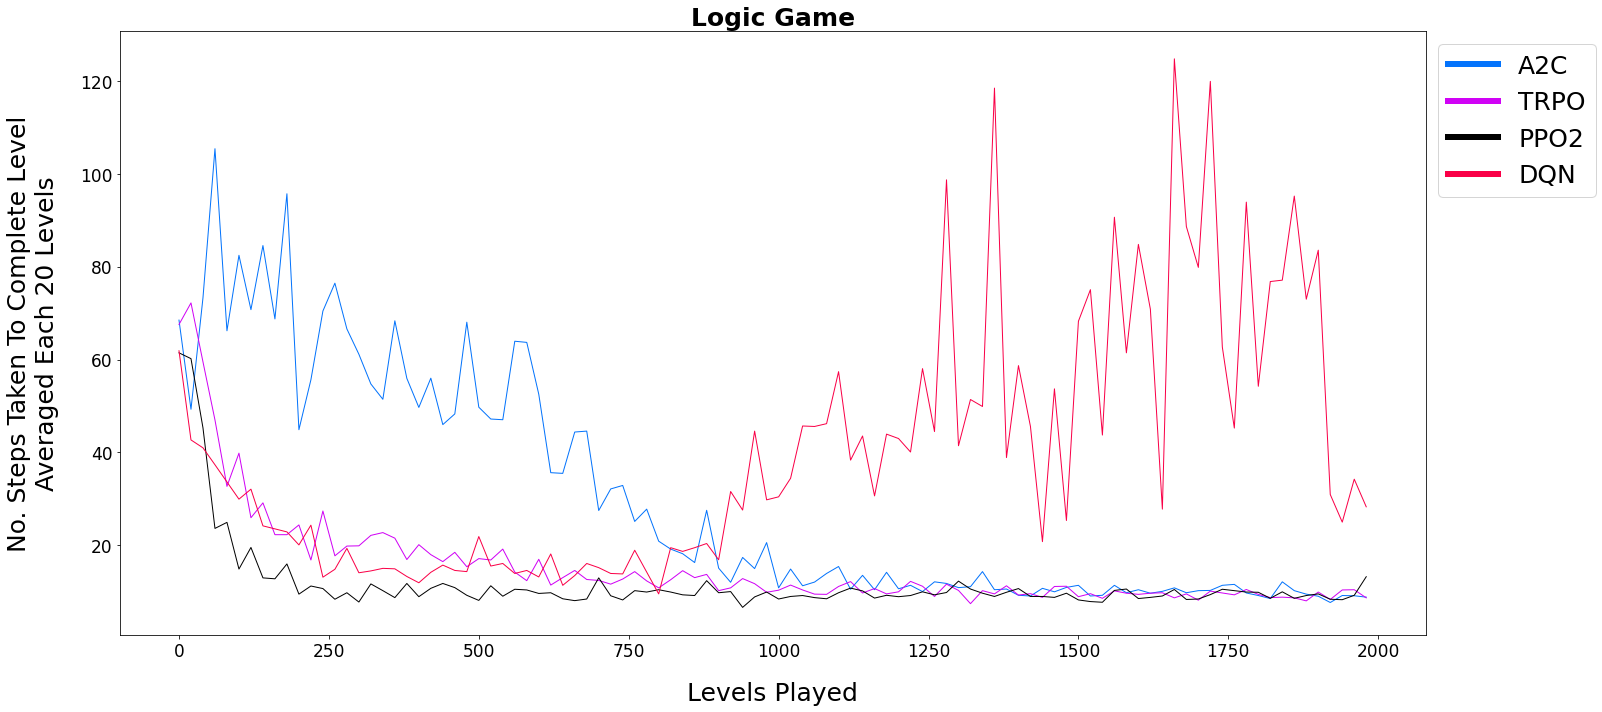

In [15]:
game_types = [ "contingency_game_shuffled_200"]  #, "change_agent_game", "contingency_game_shuffled"] #"logic_game",
agent_types = ["human", "self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training",
               "dqn_training", "random"]

batch_size = 20

for game in game_types:
    stats_dict, game_types, agent_types, batch_size = get_performance([game], agent_types,
                                                                      batch_size, single_seed=False)

    plotter(stats_dict, game_types, agent_types, batch_size, False)


# Get performance stats of extended game
# game_types_ext = ["logic_extended_game"]
# agent_types_ext = ["dqn_training", "trpo_training", "a2c_training", "acer_training"]
# stats_dict_ext, game_types_ext, agent_types_ext, y_lims_ext, batch_size_ext = get_performance(game_types_ext,
#                                                                                              agent_types_ext,
#                                                                                              y_lims, batch_size)

# appended_stats = append_stats(stats_dict, stats_dict_ext, game_types, game_types_ext, agent_types)
# plotter(appended_stats, game_types, agent_types, y_lims, batch_size, True)

In [ ]:
## ----- Plot the number of steps the player takes before any agent moves from its starting location

# Plot non-moving action count of agent for each level
def plot_nm_ac(game_types, agent_types, batch_size=50):
    for i, game_type in enumerate(game_types):
        nm_ac = get_all_nm_ac(agent_types, game_type, batch_size)

        fig, ax = plt.subplots(figsize=(20, 10))
        #ax.set_ylim([0, 5])
        #ax.set_xlim([0, 120])
        ax.xaxis.label.set_size(25)
        ax.yaxis.label.set_size(25)
        ax.set_xlabel(xlabel="Levels Played", labelpad=21)
        ax.set_ylabel(ylabel="Step Count Until Self Discovery\nAveraged Each {} Levels".format(batch_size), labelpad=21)
        ax.tick_params(axis='both', which='major', labelsize=17)
        game_label_dict = {'logic_game': "Logic Game"}
        ax.set_title(game_label_dict[game_type], fontweight='bold', fontsize=25)

        colors = ["#0373fc", "#d002f5", "#000000", "#fa0047", "#ff8903", "#00cccc", "#059607", "#ccbe00"]
        agent_label_dict = {'dqn_training': 'DQN', 'human': "Human", "self_class": "Self Class", "random": "Random",
                            'a2c_training': "A2C", 'trpo_training': 'TRPO', 'ppo2_training': 'PPO2',
                            "acer_training": "ACER"}
        for j, agent in enumerate(agent_types):
            xs = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]))]
            line_width = 4 if agent == 'human' else 1
            ax.plot(xs, nm_ac[agent + "_m"], color=colors[j], linewidth=line_width, label=agent_label_dict[agent])
            upper_curve = [nm_ac[agent + '_m'][i] + nm_ac[agent + '_se'][i] for i in
                           range(len(nm_ac[agent + '_m']))]
            lower_curve = [nm_ac[agent + '_m'][i] - nm_ac[agent + '_se'][i] for i in
                           range(len(nm_ac[agent + '_m']))]
            x = [int(i * batch_size) for i in range(0, len(nm_ac[agent + "_m"]))]
            ax.fill_between(x, lower_curve, upper_curve, alpha=0.08, color=colors[j])

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize='xx-large')

        fs = 50 if 'contingency_game' in game_type else 25
        leg = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title_fontsize=fs)
        plt.rc('legend', fontsize=fs)

        for legobj in leg.legendHandles:
            legobj.set_linewidth(6.0)

        plt.tight_layout()

        path = './plots/{}/{}/'.format(game_type, 'curves')
        if not os.path.exists(path):
            os.makedirs(path)

        fig.savefig(path + 'no_movement_action_count_{}{}.pdf'.format(game_type, batch_size), format='pdf')


# # Get non-moving action count of agent for each level and each game as a dictionary
def get_all_nm_ac(agent_types, game_type, batch_size):
    stats = {}
    for agent in agent_types:
        stats[agent + "_m"], stats[agent + "_se"] = get_nm_ac(agent, game_type, batch_size)

    return stats


# Get non-moving action count of agent for each level
def get_nm_ac(agent_type, game_type, batch_size):
    files = glob.glob("../data/" + game_type + "/" + agent_type + "/*/*.json")

    if len(files) == 0:
        files = glob.glob("../data/" + game_type + "/" + agent_type + "/*.json")

    all_seeds = []
    curr_seed = []
    seed = 0
    curr_file_count = 0
    file_amt = len(files)
    for i, file in enumerate(sorted(files, key=os.path.getmtime)):
        data = json.load(open(file))
        self_locs = data.get("data")["self_locs"]

        level_amt = 100
        action_count = [1] * level_amt

        # In each 100 levels:
        for level in range(level_amt):
            if len(self_locs[level]) == 0:
                continue
            action_amt = len(self_locs[level][0])
            for i in range(action_amt):
                if i == level_amt:
                    break

                x = self_locs[level][0][i]
                y = self_locs[level][1][i]
                x1 = self_locs[level][0][i + 1]
                y1 = self_locs[level][1][i + 1]

                if x == x1 and y == y1:  # Still in the same position
                    action_count[level] = action_count[level] + 1
                else:  # Position have changed
                    break

        curr_file_count += 1
        curr_seed.append(action_count)

        if agent_type == 'human' and (curr_file_count == file_amt or file_amt == 1):
            all_seeds = curr_seed
            break

        if agent_type != 'human' and curr_file_count == 20:
            all_seeds.append(curr_seed)
            curr_seed = []
            curr_file_count = 0
            seed += 1

    all_seeds = pd.DataFrame(all_seeds)

    seed_average = []
    seed_sem = []
    for column in all_seeds:
        seed_average.append(np.mean(list(all_seeds[column]), axis=0))
        seed_sem.append((pd.DataFrame(list(all_seeds[column]))).sem(axis=0))

    curr_avg_data = pd.DataFrame(seed_average).T
    curr_sem_data = pd.DataFrame(seed_sem).T

    if agent_type != 'human':
        seed_mean = np.array(
            [curr_avg_data[column].groupby(curr_avg_data.index // batch_size).mean() for column in
             curr_avg_data]).reshape(
            int(curr_avg_data.shape[1] * 100 * 1 / batch_size))
        s_sem = np.array(
            [curr_sem_data[column].groupby(curr_sem_data.index // batch_size).sem() for column in
             curr_sem_data]).reshape(
            int(curr_sem_data.shape[1] * 100 * 1 / batch_size))
    else:
        temp = np.asarray(curr_avg_data).T
        avg_ma = [temp[i:i + batch_size].mean() for i in range(0, curr_avg_data.shape[1] - batch_size + 1, batch_size)]

        temp = np.asarray(curr_sem_data).T
        avg_se = [temp[i:i + batch_size].mean() for i in range(0, curr_sem_data.shape[1] - batch_size + 1, batch_size)]

        seed_mean = np.array(avg_ma).reshape(int(curr_avg_data.shape[1] / batch_size))
        s_sem = np.array(avg_se).reshape(int(curr_sem_data.shape[1] / batch_size))

    return seed_mean, s_sem

In [ ]:
agent_types = ["human", "self_class", "a2c_training", "trpo_training", "acer_training", "ppo2_training",
               "dqn_training", "random"]
game_types = ["logic_game"]  #, "contingency_game", "change_agent_game", "contingency_game_shuffled"
plot_nm_ac(game_types, agent_types)